In [1]:
%matplotlib notebook

import pockpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Initialization from `.tfs` files

In [2]:
# Initialize the Twiss table in the Solver

tfs_filename_dict = {
    'LHCB1' : '../tests/data/testb1.tfs',
    'LHCB2' : '../tests/data/testb2.tfs'
}
solver = pockpy.Solver(tfs_filename_dict=tfs_filename_dict)

In [3]:
# Build the response matrices

# Analyze only the region Q25->Q25 around IP5
section = {
    'LHCB1' : ('MQ.25L5.B1', 'MQ.25R5.B1'),
    'LHCB2' : ('MQ.25L5.B2', 'MQ.25R5.B2')
}
solver.build_matrices(section=section)

Computing corrector matrix..
Computing error matrix..


## Do things

<IPython.core.display.Javascript object>


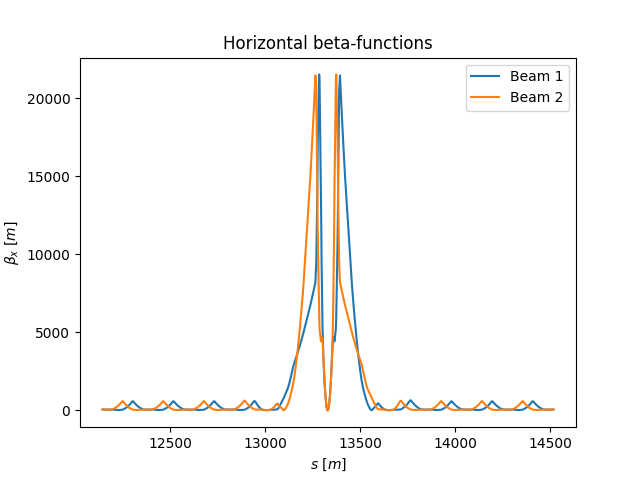

In [4]:
# Plot the beta function
tt = solver.twiss_table
plt.figure()
plt.plot(tt.loc['LHCB1']['S'], tt.loc['LHCB1']['BETX'], label='Beam 1')
plt.plot(tt.loc['LHCB2']['S'], tt.loc['LHCB2']['BETX'], label='Beam 2')
plt.xlabel('$s$ [$m$]')
plt.ylabel('$\\beta_x$ [$m$]')
plt.legend()
plt.title('Horizontal beta-functions')
plt.show()

<IPython.core.display.Javascript object>


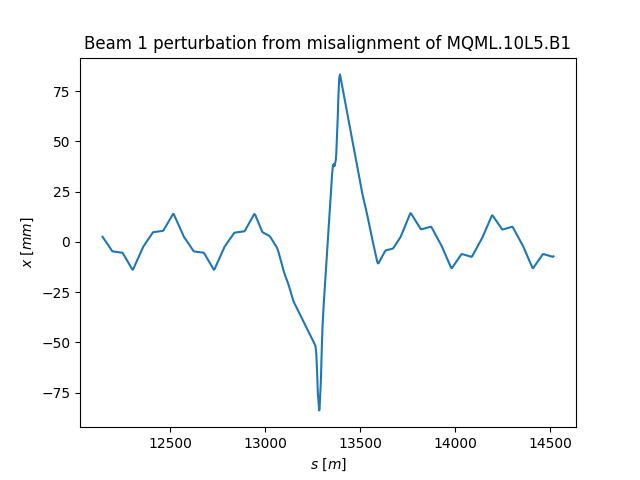

In [5]:
# Show the perturbation from horizontally misaligning MQML.10L5.B1 horizontally 2 mm

solver.reset_errors()
error_dict = {
    'QUADRUPOLE' : {
        'MQML.10L5.B1' : {
            'DX' : 2e-3
        }
    }
}
solver.add_errors(error_dict)

perturbation = solver.compute_perturbation()

s = tt.loc['LHCB1']['S']
plt.figure()
plt.plot(s, 1e3*perturbation.loc['LHCB1', 'X'])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [$mm$]')
plt.title('Beam 1 perturbation from misalignment of MQML.10L5.B1')
plt.show()

<IPython.core.display.Javascript object>


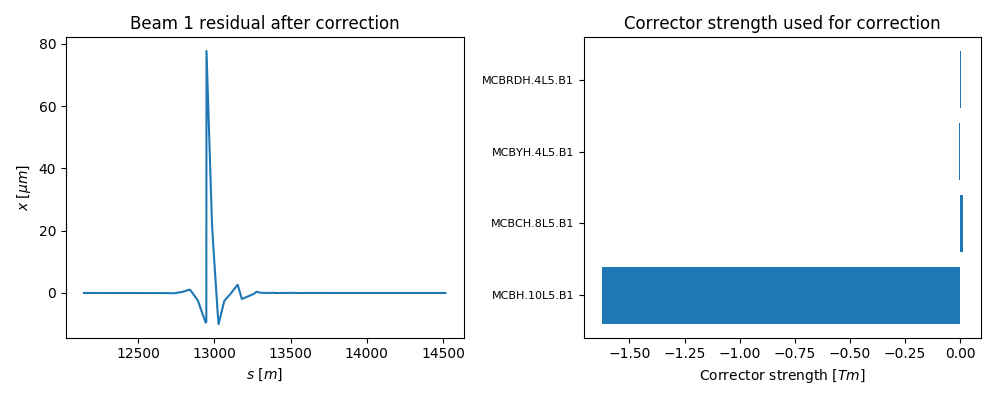

In [6]:
# Correct for the previous error via a pseudoinverse with 50 singular values per plane
corrector_strength, residual = solver.linear_correction(n_x=50, n_y=50)

plt.figure(figsize=(10,4))
plt.subplot(121)

s = tt.loc['LHCB1']['S']
plt.plot(s, 1e6*residual.loc['LHCB1', 'X'])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [$\mu m$]')
plt.title('Beam 1 residual after correction')

plt.subplot(122)

cs = corrector_strength[corrector_strength.abs() > 2e-3]
bars = [x for x in range(cs.shape[0])]

plt.title('Corrector strength used for correction')
plt.barh(bars, cs, tick_label=cs.index)
plt.yticks(fontsize=8)
plt.xlabel('Corrector strength [$Tm$]')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


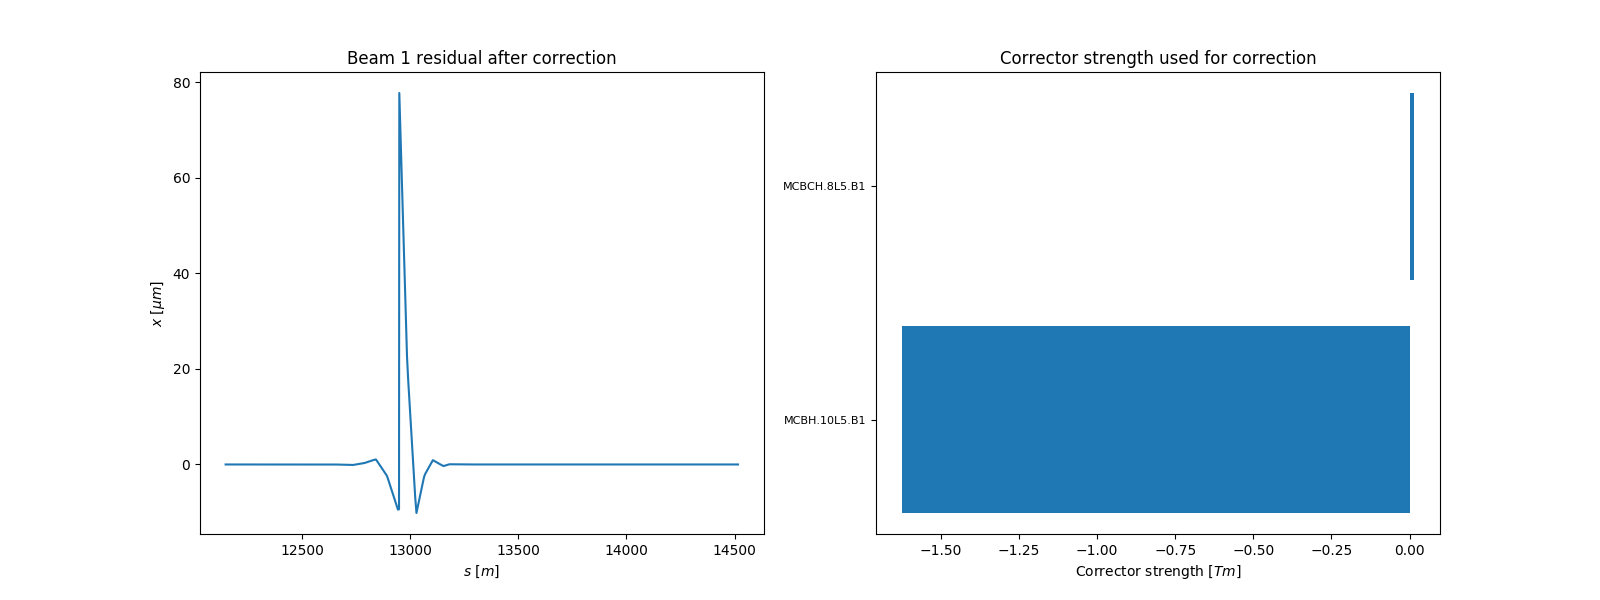

In [7]:
# Correct for the previous error via constrained optimization, to achieve ~ the same correction

# We want less than 20 mum orbit for the residual
orbit_bound = solver.get_bpm_reading_series()
orbit_bound[:] = 200e-6

# And no more than 2 Tm used for any one corrector
cs_bound = solver.get_corrector_series()
cs_bound[:] = 2.0

corrector_strength, residual = solver.convex_correction(orbit_bound=orbit_bound, cs_bound=cs_bound)

plt.figure(figsize=(16,6))
plt.subplot(121)

s = tt.loc['LHCB1']['S']
plt.plot(s, 1e6*residual.loc['LHCB1', 'X'])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [$\mu m$]')
plt.title('Beam 1 residual after correction')

plt.subplot(122)

# Show only the correctors that are used the most
cs = corrector_strength[corrector_strength.abs() > 1e-2]
bars = [x for x in range(cs.shape[0])]

plt.title('Corrector strength used for correction')
plt.barh(bars, cs, tick_label=cs.index)
plt.yticks(fontsize=8)
plt.xlabel('Corrector strength [$Tm$]')
plt.show()

<IPython.core.display.Javascript object>


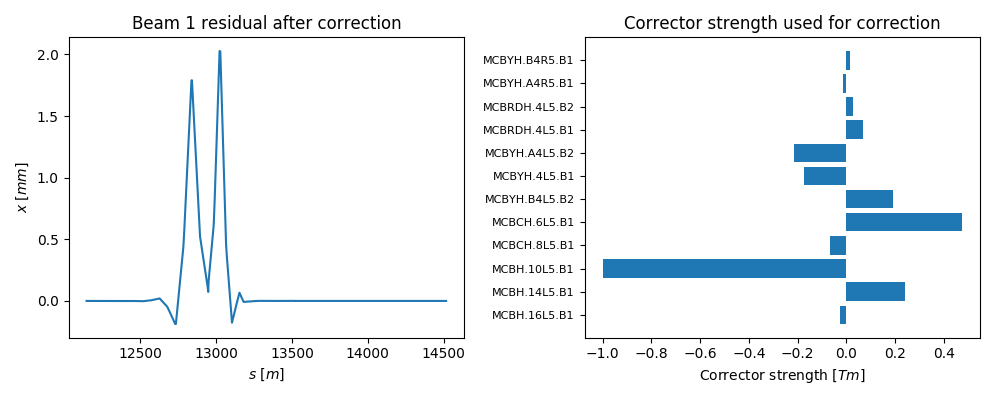

In [8]:
# Correct for the previous error via constrained optimization, to achieve a 'worse' correction

# We want less than 2 mm orbit for the residual
orbit_bound = solver.get_bpm_reading_series()
orbit_bound[:] = 2e-3

# And no more than 1 Tm used for any one corrector
cs_bound = solver.get_corrector_series()
cs_bound[:] = 1.0

corrector_strength, residual = solver.convex_correction(orbit_bound=orbit_bound,
                                                        cs_bound=cs_bound)

plt.figure(figsize=(10,4))
plt.subplot(121)

s = tt.loc['LHCB1']['S']
plt.plot(s, 1e3*residual.loc['LHCB1', 'X'])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [$mm$]')
plt.title('Beam 1 residual after correction')

plt.subplot(122)

# Show only the correctors that are used the most
cs = corrector_strength[corrector_strength.abs() > 1e-2]
bars = [x for x in range(cs.shape[0])]

plt.title('Corrector strength used for correction')
plt.barh(bars, cs, tick_label=cs.index)
plt.yticks(fontsize=8)
plt.xlabel('Corrector strength [$Tm$]')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


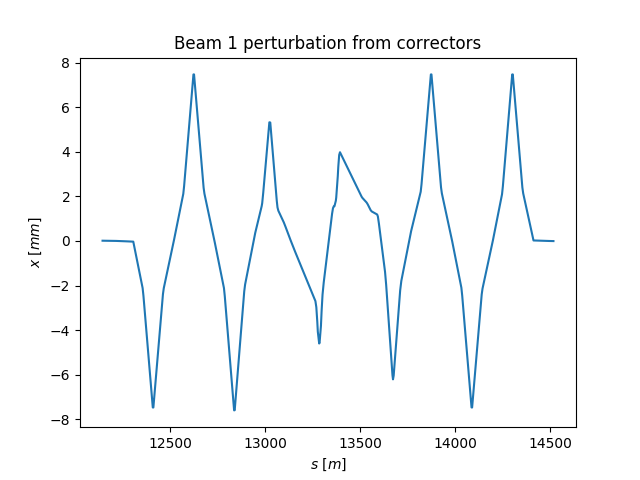

In [9]:
# Directly make use of response matrices

tt = solver.twiss_table
RMc = solver.corrector_response_matrix
RMe = solver.error_response_matrix
cs = pd.Series(0.0, index=RMc.columns)

# E.g., compute the impact of adding 1 Tm to MCBH.23R5.B1 and -1 Tm to MCBH.22L5.B1
cs['MCBH.23R5.B1'] = 1.0
cs['MCBH.22L5.B1'] = -1.0

orbit = RMc @ cs

s = tt.loc['LHCB1']['S']
plt.figure()
plt.title('Beam 1 perturbation from correctors')
plt.plot(s, 1e3*orbit.loc['LHCB1', 'X'])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [$mm$]')
plt.show()

## Directly manipulate the error table

In [10]:
solver.error_table

TYPE    ERR_ELMT     ERR_TYPE
DIPOLE  MB.C25L5.B1  DKR0        0.0
                     DPSI        0.0
                     DX          0.0
                     DY          0.0
        MB.B25L5.B1  DKR0        0.0
                                ... 
BPM     BPM.23R5.B2  DY          0.0
        BPM.24R5.B2  DX          0.0
                     DY          0.0
        BPM.25R5.B2  DX          0.0
                     DY          0.0
Length: 1508, dtype: float64

<IPython.core.display.Javascript object>


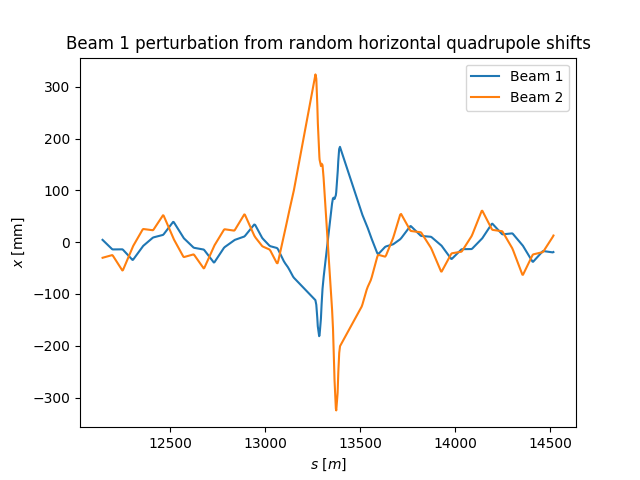

In [11]:
solver.error_table[:] = 0.0 # Reset all errors

# Have all quadrupole experience a random horizontal shift on the interval [-1mm, 1mm]
solver.error_table.loc['QUADRUPOLE', :, 'DX'] = np.random.uniform(
    -1e-3, 1e-3, solver.error_table.loc['QUADRUPOLE', :, 'DX'].shape)

# Compute the induced perturbation
orbit = RMe @ solver.error_table

plt.figure()
plt.title('Beam 1 perturbation from random horizontal quadrupole shifts')
for beam in ['LHCB1', 'LHCB2']:
    s = tt.loc[beam]['S']
    plt.plot(s, 1e3*orbit.loc[beam, 'X'], label='Beam ' + beam[-1])
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [mm]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


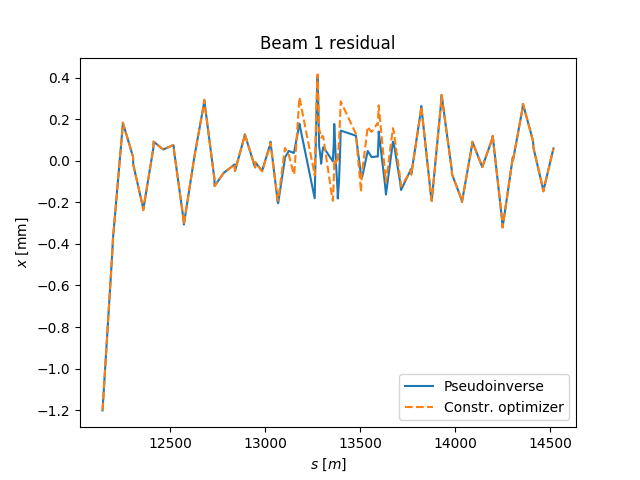

In [12]:
# And we can correct for this error like before

# With a pseudoinverse..
__, residual_pseudo = solver.linear_correction(n_x=50, n_y=50)

# .. and with a constrained optimization
orbit_bound[:] = 4e-3
cs_bound[:] = 1

__, residual_convex = solver.convex_correction(orbit_bound=orbit_bound,
                                               cs_bound=cs_bound)

# Show for Beam 1
plt.figure()
plt.title('Beam 1 residual')
s = tt.loc['LHCB1']['S']
plt.plot(s, 1e3*residual_pseudo.loc['LHCB1', 'X'], label='Pseudoinverse')
plt.plot(s, 1e3*residual_convex.loc['LHCB1', 'X'], label='Constr. optimizer', ls='--')
plt.xlabel('$s$ [$m$]')
plt.ylabel('$x$ [mm]')
plt.legend()
plt.show()
